# Part 1: Data selection and preparation

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmt

eq_data_dir = f"{os.getcwd()}/../data/eq_data"
cat_folder = f"{eq_data_dir}/1_eq_catalogs/"        # usgs catalog and slab2 data folder
fault_data_dir = f"../data/USGS-Fault"      # usgs fault data folder
topo_data = f"./Mapping/GMRTv4_2_122-128w_39-42.grd"
aboveslab_eq_file = f'{cat_folder}/usgs_eq_above_slab2_all.csv'   # eqs above slab2

aboveslab_eq_df = pd.read_csv(aboveslab_eq_file, parse_dates=["time"])
aboveslab_eq_df.shape
# selected_eqs = pd.read_csv(selected_eq_file) 


(921, 23)

### Load the regional Faults into a dictionary

In [2]:
# get list of fault file names
fault_files = os.listdir(fault_data_dir)
fault_files.sort()

usgs_fault_dir = f"../data/USGS-Fault"
mtj_faults = []
# get all filepaths in the directory and subdirectories 
for root, dirs, files in os.walk(usgs_fault_dir):
    for file in files:
        if file.endswith(".txt"):
            mtj_faults.append(os.path.join(root, file))

mtj_faults.sort()        

# read the fault data
faults_dict_np = {}
for fault_file in mtj_faults:
    fault_name = fault_file.split('/')[-1][:-4]
    if 'contour' in fault_name.split('_'):
        continue
    faults_dict_np[fault_name] = np.loadtxt(fault_file, delimiter=' ')
    # print(fault_name)

# read slab2 contours
slab2_contours_dict = {}
for contour in os.listdir(f"{usgs_fault_dir}/slab2_dep_contour"):
    cont_name = contour[:-4]
    slab2_contours_dict[cont_name] = np.loadtxt(f"{usgs_fault_dir}/slab2_dep_contour/{contour}", delimiter=' ')
    

# Make a shaded topo map with earthquakes

plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 21 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data a

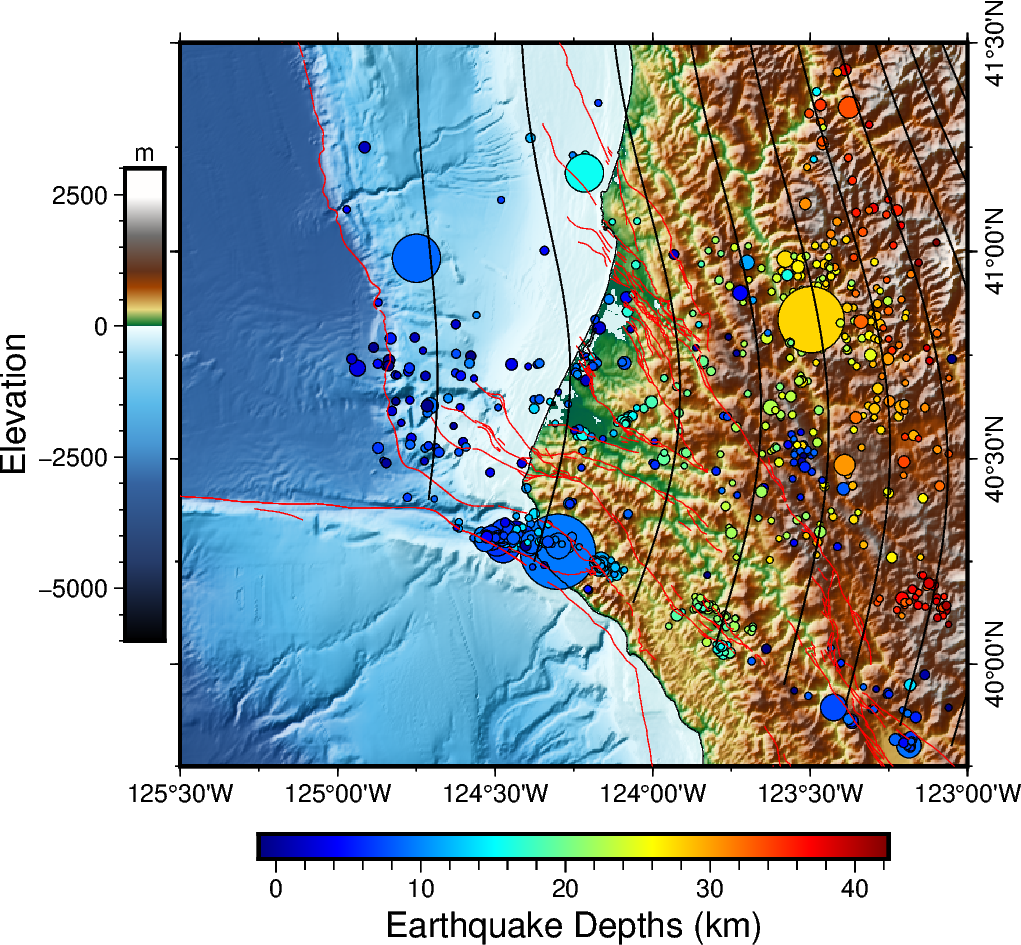

In [3]:
# region=[-128, -122, 39, 42]
region = [-125.5, -123, 39.75, 41.5]

proj="M10c"
azi="0/90"
nor="e1" # normalize the intensity

fig = pygmt.Figure()

# Define color palette
pygmt.makecpt(cmap="geo", series=[-6000, 3000])

# Define figure configuration
with pygmt.config(
    FONT_TITLE="10p,5",
    MAP_TITLE_OFFSET="1p",
    MAP_FRAME_TYPE="plain",
    MAP_ANNOT_OBLIQUE="lat_parallel"
    ):

    # Making an intensity DataArray using azimuth and normalize parameters
    shade = pygmt.grdgradient(grid=topo_data, azimuth=azi, normalize=nor)

    # Plot the topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection=proj,
        shading=True,
        frame=['SEnw', "xa0.5f0.25", "ya0.5f0.25"], # +tHillshade Map
        cmap=True,
        
        )
        
    # add colorbar
    fig.colorbar(
        position="JML+o0.2c/0c+w6c/0.5c", # +o: offset, +w: width
        # position="x-0.75c/0.75c+w5c/0.5c+m+v+e", # +m: text position, +v: vertical, +e: triangles outside
        frame=["a2500f500+lElevation", "y+lm"]
        )
    
        
# make a color palette
pygmt.makecpt(cmap="jet", series=[aboveslab_eq_df.depth.min(), aboveslab_eq_df.depth.max()])

# plot the selected earthquakes with bigger size [proporional to magnitude]
fig.plot(
    x=aboveslab_eq_df['longitude'],
    y=aboveslab_eq_df['latitude'],
    size=0.02 * (2 ** aboveslab_eq_df.mag),
    fill=aboveslab_eq_df.depth,
    cmap=True,
    style="cc",
    pen="black",
    # label="Selected Earthquakes",
    )
# add colorbar for earthquake depths
fig.colorbar(frame="xaf+lEarthquake Depths (km)")

# # add legend for the earthquake magnitudes 2-7 [6 circles with different sizes] # show only 3 circles
# fig.plot(
#     x=np.array([-125.5, -125.5, -125.5, -125.5, -125.5, -125.5])-2.1,
#     y=np.array([40.5, 40.55, 40.65, 40.8, 41.1, 41.6])-1.4,
#     size=0.1 * (2 ** np.arange(2, 8)),
#     style="cc",
#     fill="white",
#     pen="black",
#     # label="Magnitude 2-7",
#     )

# # add a box to show the selected area
# fig.plot(
#     x=[-125.5, -123, -123, -125.5, ],
#     y=[39.75, 39.75, 41.5, 41.5, ],
#     pen="0.5p,black",
#     close=True,
#     label="Selected Area",
#     )

# plot faultline
for i, fault_name in enumerate(faults_dict_np.keys()):
    fig.plot(
        x=faults_dict_np[fault_name][:,0], # 1st column is longitude
        y=faults_dict_np[fault_name][:,1], # 2nd column is latitude 
        pen='.25p,red',
        # label=fault_name,
    )

# plot slab2 contours
for i, cont_name in enumerate(slab2_contours_dict.keys()):
    fig.plot(
        x=slab2_contours_dict[cont_name][:,0], # 1st column is longitude
        y=slab2_contours_dict[cont_name][:,1], # 2nd column is latitude 
        pen='.5p,black',
        # label=cont_name,
    )

# add coastlines
fig.coast(region=region, projection=proj, shorelines=True)

# limit the map to the selected area

fig.show(dpi=200, width=1000)

plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 21 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data a

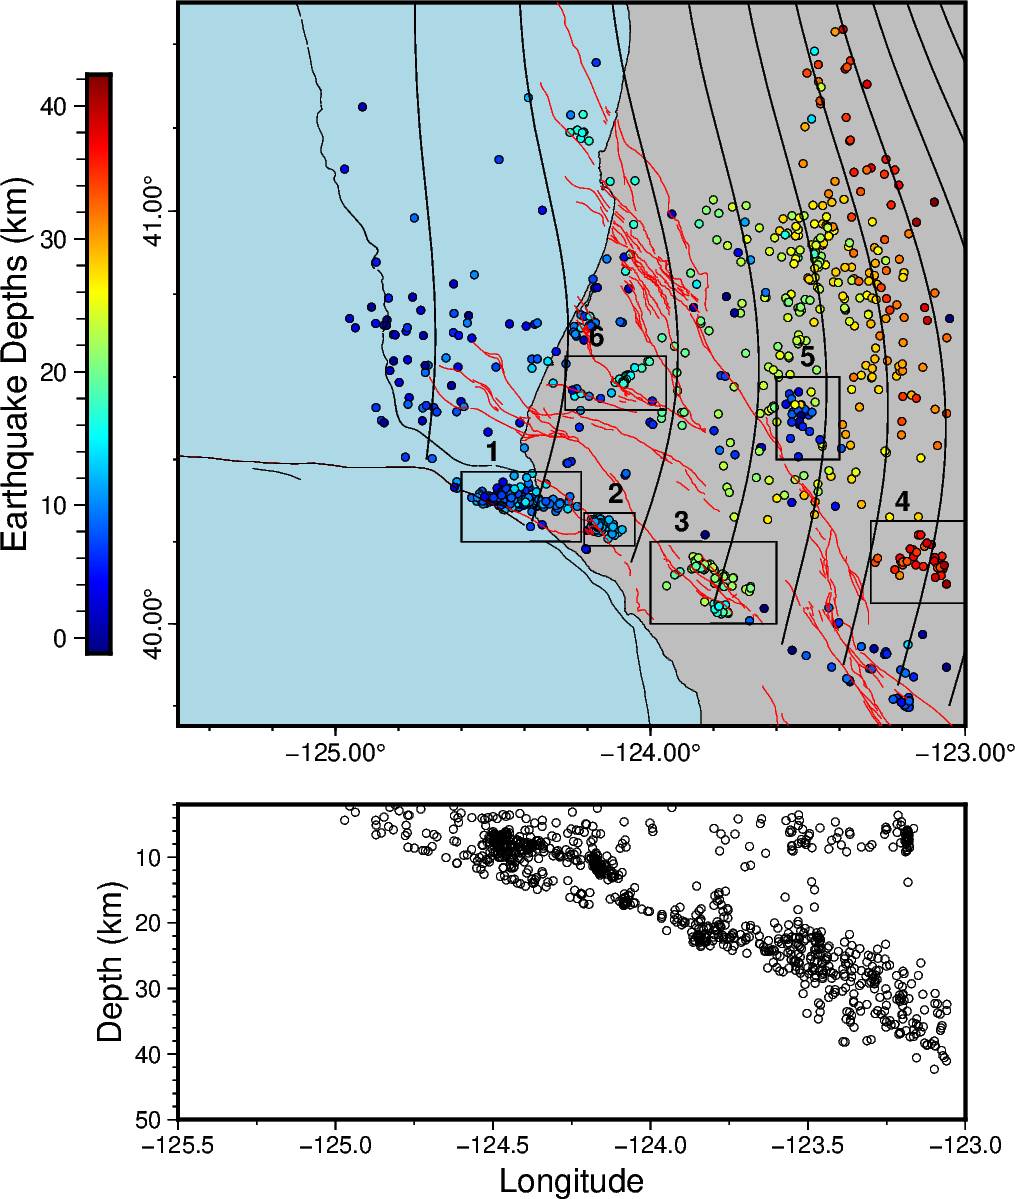

In [4]:
# region=[-128, -122, 39, 42]
region = [-125.5, -123, 39.75, 41.5]

proj="M10c"
azi="0/90"
nor="e1" # normalize the intensity

fig = pygmt.Figure()

# Define color palette
pygmt.makecpt(cmap="geo", series=[-6000, 3000])

# Define figure configuration
with pygmt.config(
    FONT_TITLE="10p,5",
    MAP_TITLE_OFFSET="1p",
    MAP_FRAME_TYPE="plain",
    FORMAT_GEO_MAP="ddd.xx",
    MAP_ANNOT_OBLIQUE="lat_parallel"
    ):

    # add coastlines
    fig.coast(
        region=region, 
        projection=proj, 
        shorelines=True,
        land="gray",
        water="lightblue",
        frame=["a1f0.2",]
        )
        
# make a color palette
pygmt.makecpt(cmap="jet", series=[aboveslab_eq_df.depth.min(), aboveslab_eq_df.depth.max()])

# plot the selected earthquakes with bigger size [proporional to magnitude]
fig.plot(
    x=aboveslab_eq_df['longitude'],
    y=aboveslab_eq_df['latitude'],
    style="c0.1c",
    pen="black",
    fill=aboveslab_eq_df.depth,
    cmap=True,
    
)
    
# add colorbar for earthquake depths
fig.colorbar(frame="x+lEarthquake Depths (km)", position="JL")

# plot faultline
for i, fault_name in enumerate(faults_dict_np.keys()):
    if fault_name in ['Cascadia', 'SAF', 'MTZ']:
        pen_color = 'black'
    else:
        pen_color = 'red'

    fig.plot(
        x=faults_dict_np[fault_name][:,0], # 1st column is longitude
        y=faults_dict_np[fault_name][:, 1], # 2nd column is latitude 
        pen=f'.25p,{pen_color}',
        # label=fault_name,
    )

# plot slab2 contours
for i, cont_name in enumerate(slab2_contours_dict.keys()):
    fig.plot(
        x=slab2_contours_dict[cont_name][:,0], # 1st column is longitude
        y=slab2_contours_dict[cont_name][:,1], # 2nd column is latitude 
        pen='.5p,black',
        # label=cont_name,
    )


# plot boxes around earthquake clusters
clusters = np.array([
    [1, -124.6, -124.22, 40.2, 40.37],
    [2, -124.21, -124.05, 40.19, 40.27],
    [3, -124.0, -123.6, 40.0, 40.2],
    [4, -123.3, -123, 40.05, 40.25],
    [5, -123.6, -123.4, 40.4, 40.6],
    [6, -124.27, -123.95, 40.52, 40.65],
])

for i in range(clusters.shape[0]):
    fig.plot(
        x=clusters[i, [1, 2, 2, 1, 1]],
        y=clusters[i, [3, 3, 4, 4, 3]],
        pen="0.5p,black",
        close=True,
        label=f"{clusters[i, 0]}",
        )
    # show the cluster name
    fig.text(
        x=np.float32(clusters[i, 1]) + 0.1,
        y=np.float32(clusters[i, 4]) + 0.05,
        text=f"{int(clusters[i, 0])}",
        font="10p,Helvetica-Bold,black",
        )


# plot cross-section with earthquakes
# Shift plot origin 12.5 centimeters to the bottom
fig.shift_origin(yshift="-5c")

fig.basemap(
    region=[-125.5, -123, 2, 50],
    projection="X10c/-4c",      # -6c to flip the y-axis
    frame=["WSrt", "xa0.5f0.25+lLongitude", "ya10f2+lDepth (km)"],
)

fig.plot(
    x=aboveslab_eq_df['longitude'],
    y=aboveslab_eq_df['depth'],
    style="c0.1c",
    pen="black",
    # fill=aboveslab_eq_df.depth,
    # cmap=True,
)


fig.show(dpi=200, width=1000)

In [18]:
sta_df = pd.read_csv('../data/eq_data/3_station_catalogs/00_station_inventory_master.txt',
                     sep='|')
print(sta_df.shape)

# unique stations
sta_df = sta_df.drop_duplicates(subset=['Station'])
print(sta_df.shape)


(23520, 17)
(1258, 17)


plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 21 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 2 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 3 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 4 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 5 contains NaNs - no resampling taken place!
plot [WARNING]: Your data a

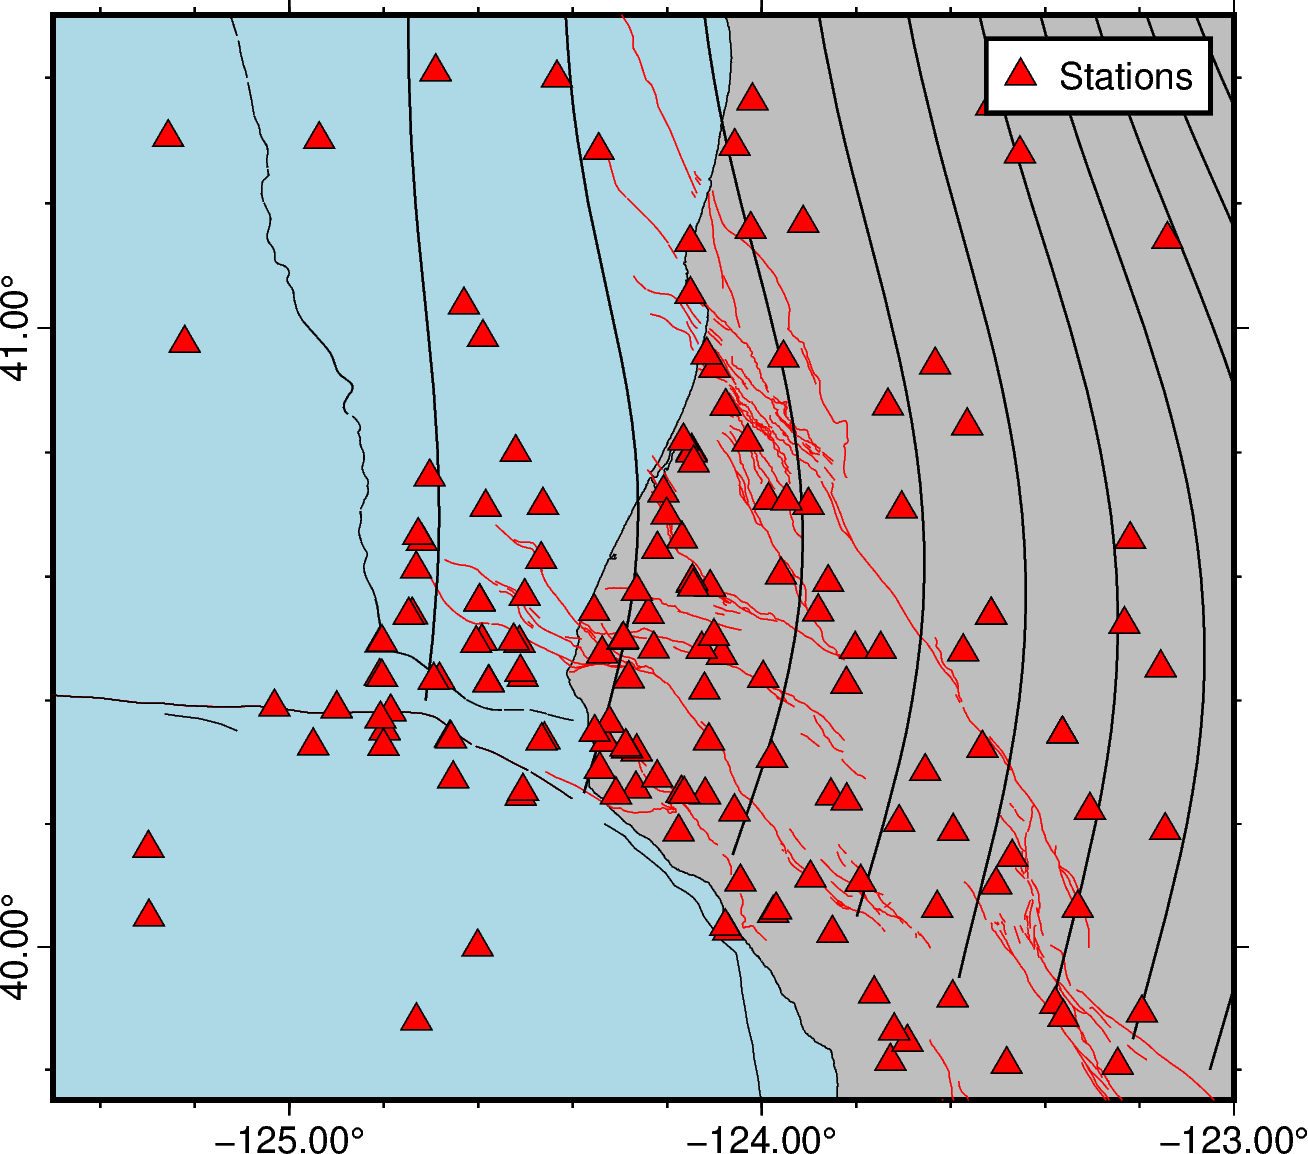

In [21]:

# region=[-128, -122, 39, 42]
region = [-125.5, -123, 39.75, 41.5]

proj="M10c"
azi="0/90"
nor="e1" # normalize the intensity

fig = pygmt.Figure()

# Define color palette
pygmt.makecpt(cmap="geo", series=[-6000, 3000])

# Define figure configuration
with pygmt.config(
    FONT_TITLE="10p,5",
    MAP_TITLE_OFFSET="1p",
    MAP_FRAME_TYPE="plain",
    FORMAT_GEO_MAP="ddd.xx",
    MAP_ANNOT_OBLIQUE="lat_parallel"
    ):

    # add coastlines
    fig.coast(
        region=region, 
        projection=proj, 
        shorelines=True,
        land="gray",
        water="lightblue",
        frame=["WSne", "a1f0.2",]
        )
    

# plot faultline
for i, fault_name in enumerate(faults_dict_np.keys()):
    if fault_name in ['Cascadia', 'SAF', 'MTZ']:
        pen_color = 'black'
    else:
        pen_color = 'red'

    fig.plot(
        x=faults_dict_np[fault_name][:,0], # 1st column is longitude
        y=faults_dict_np[fault_name][:, 1], # 2nd column is latitude 
        pen=f'.25p,{pen_color}',
        # label=fault_name,
    )

# plot slab2 contours
for i, cont_name in enumerate(slab2_contours_dict.keys()):
    fig.plot(
        x=slab2_contours_dict[cont_name][:,0], # 1st column is longitude
        y=slab2_contours_dict[cont_name][:,1], # 2nd column is latitude 
        pen='.5p,black',
        # label=cont_name,
    )
    
# plot stations
fig.plot(
    x=sta_df['Longitude'],
    y=sta_df['Latitude'],
    style="t0.3c",
    color="red",
    pen="black",
    label="Stations",
    )          

fig.legend()
fig.show()